In [1]:
import torch
import torch.nn as neural
import torch.nn.functional as function
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms, models,

import kagglehub
path = kagglehub.dataset_download("mehradaria/leukemia")
path2 = kagglehub.dataset_download("mehradaria/leukemia")

path = path + "/Original"
path2 = path2 + "/Segmented"

print(path)
print(path2)

#datasets
dataset = datasets.ImageFolder(root=path, transform=transforms.ToTensor())
dataset_segmented = datasets.ImageFolder(root=path2, transform=transforms.ToTensor())

path2 = kagglehub.dataset_download("mehradaria/leukemia")


train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)


images, labels = next(iter(train_loader))
print(images.shape)
print(labels)

classes = ["Bening", "Early", "Pre", "Pro"]


for label in dataset.classes:
    print(label)



100%|██████████| 110M/110M [00:03<00:00, 29.6MB/s]

Extracting files...


/root/.cache/kagglehub/datasets/mehradaria/leukemia/versions/1/Original
/root/.cache/kagglehub/datasets/mehradaria/leukemia/versions/1/Segmented
torch.Size([64, 3, 224, 224])
tensor([3, 1, 3, 1, 2, 1, 0, 1, 1, 0, 1, 2, 0, 1, 1, 2, 2, 3, 2, 3, 1, 2, 2, 1,
        3, 1, 1, 3, 1, 2, 2, 0, 3, 0, 2, 1, 1, 3, 1, 3, 2, 0, 2, 0, 3, 2, 0, 2,
        1, 2, 3, 0, 0, 3, 0, 2, 2, 1, 1, 1, 2, 2, 0, 3])
Benign
Early
Pre
Pro


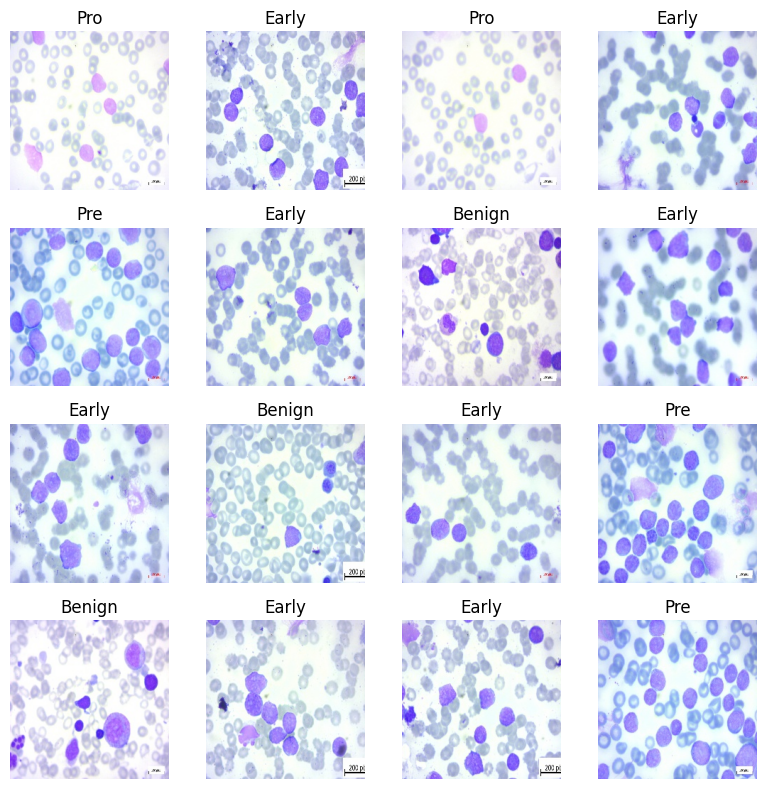

In [3]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    img = images[i].permute(1, 2, 0,).numpy()
    label = dataset.classes[labels[i]]
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [4]:
#funciones útiles
def get_optimizer(optimizer, model, lr): #selector de optimizador
    if optimizer == 1:
         return torch.optim.SGD(model.parameters(), lr=lr)
    if optimizer == 2:
        return torch.optim.Adam(model.parameters(), lr=lr)
    if optimizer == 3:
        return torch.optim.RMSprop(model.parameters(), lr=lr)
    if optimizer == 4:
        return torch.optim.Adadelta(model.parameters(), lr=lr)

def calculate_w(w, f, p, s): #calculo de tamaño de salida de una capa convolucional
    return int((w - f + 2 * p) / s + 1)

In [5]:
class CNN(neural.Module):
    def __init__(self,learning_rate, loss_function, optimizer, kernel_sizes):
        super(CNN, self).__init__()
        #hiperparametetros
        self.learning_rate = learning_rate
        self.loss_function = loss_function
        #self.config = config
        self.kernel_sizes = kernel_sizes #kernel_sizes[0] = 5*5, #kernel_sizes[1] = 3*

        #output size = (W - F + 2P)/S + 1 , W = input size, F = filter size, P = padding, S = stride
        #conv1:  W = 224, F = 5, P = 0, S = 1  -> 220
        #pool: W=220, F = 2, P = 0, S = 2  -> 110
        #conv2: W = 110, F = 3, P = 0, S = 1  -> 108
        #pool: W=108, F = 2, P = 0, S = 2  -> 54

        #arquitectura de capas
        self.conv1 = neural.Conv2d(3, 6, kernel_sizes[0])
        self.pool = neural.MaxPool2d(2, 2)
        self.conv2 = neural.Conv2d(6, 16, kernel_sizes[1])
        self.linear = neural.Linear(16 * 54 * 54, 128)
        self.linear2 = neural.Linear(128, 64)
        self.output = neural.Linear(64, 4)

        self.optimizer = get_optimizer(optimizer, self, learning_rate)




    def forward(self,x):
        x = function.relu(self.conv1(x))
        x = self.pool(x)
        x = function.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16 * 54 * 54)
        x = function.relu(self.linear(x))
        x = function.relu(self.linear2(x))
        x = self.output(x)
        return x


In [19]:
#Configuración externa y manual de hiperparámetros
disp = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", disp)

learning_rate = 0.001
batch_size = 64
num_epochs = 100
kernel_sizes = [5,3]

loss_function = torch.nn.CrossEntropyLoss()
optimizer = 2

Using device: cuda


In [43]:
import matplotlib.pyplot as plt

def plot_loses(train_losses, val_accuracies):
  # Plot training loss
  plt.figure(figsize=(10, 5))
  plt.plot(train_losses, label='Training Loss')
  plt.title("Training Loss Curve")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

  # Plot validation accuracy
  plt.figure(figsize=(10, 5))
  plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
  plt.title("Validation Accuracy Curve")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend()
  plt.show()

In [67]:
def train_model(model, train_loader, val_loader, num_epochs, device):
    best_acc = 0
    train_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            model.optimizer.zero_grad()
            outputs = model(images)
            loss = model.loss_function(outputs, labels)
            loss.backward()
            model.optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        # --- VALIDATION ---
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        val_accuracies.append(acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_loss:.4f} | Val Acc: {acc:.2f}%")

        # Save best model
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), "best_model.pth")

    # Return metrics for plotting
    return train_losses, val_accuracies


In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(model, test_loader, device, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcular matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)

    # Graficar con seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [72]:
from sklearn.metrics import f1_score
def test_model(model, test_loader, device, train_losses, val_accuracies):
    # Cargar el modelo entrenado si es que guardaste "best_model.pth"
    model.load_state_dict(torch.load("best_model.pth", map_location=device))
    model.to(device)
    model.eval()

    correct = 0
    total = 0
    running_loss = 0.0

    all_labels = []
    all_preds = []

    with torch.no_grad():  # no necesitamos gradientes en test
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = model.loss_function(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_preds, average='macro')


    print(f"Test Loss: {avg_loss:.4f} | Test Accuracy: {accuracy:.2f}% | F1 Score: {f1:.4f}")

    plot_loses(train_losses, val_accuracies)
    plot_confusion_matrix(model, test_loader, disp, class_names=classes)

In [35]:
#Crear y entrenar un modelo

model = CNN(learning_rate, loss_function, optimizer, kernel_sizes).to(disp)
train_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs, disp)

Epoch [1/100] | Train Loss: 1.1356 | Val Acc: 70.46%
Epoch [2/100] | Train Loss: 0.6309 | Val Acc: 73.85%
Epoch [3/100] | Train Loss: 0.5242 | Val Acc: 77.85%
Epoch [4/100] | Train Loss: 0.4016 | Val Acc: 79.08%
Epoch [5/100] | Train Loss: 0.4791 | Val Acc: 79.69%
Epoch [6/100] | Train Loss: 0.2850 | Val Acc: 78.46%
Epoch [7/100] | Train Loss: 0.2900 | Val Acc: 82.77%
Epoch [8/100] | Train Loss: 0.1685 | Val Acc: 81.54%
Epoch [9/100] | Train Loss: 0.1159 | Val Acc: 80.62%
Epoch [10/100] | Train Loss: 0.0800 | Val Acc: 82.15%
Epoch [11/100] | Train Loss: 0.0440 | Val Acc: 81.23%
Epoch [12/100] | Train Loss: 0.0277 | Val Acc: 84.31%
Epoch [13/100] | Train Loss: 0.0170 | Val Acc: 83.69%
Epoch [14/100] | Train Loss: 0.0126 | Val Acc: 85.23%
Epoch [15/100] | Train Loss: 0.0055 | Val Acc: 84.62%
Epoch [16/100] | Train Loss: 0.0036 | Val Acc: 83.69%
Epoch [17/100] | Train Loss: 0.0024 | Val Acc: 84.00%
Epoch [18/100] | Train Loss: 0.0019 | Val Acc: 84.31%
Epoch [19/100] | Train Loss: 0.0016 |

Test Loss: 0.5826 | Test Accuracy: 81.65% | F1 Score: 0.7804


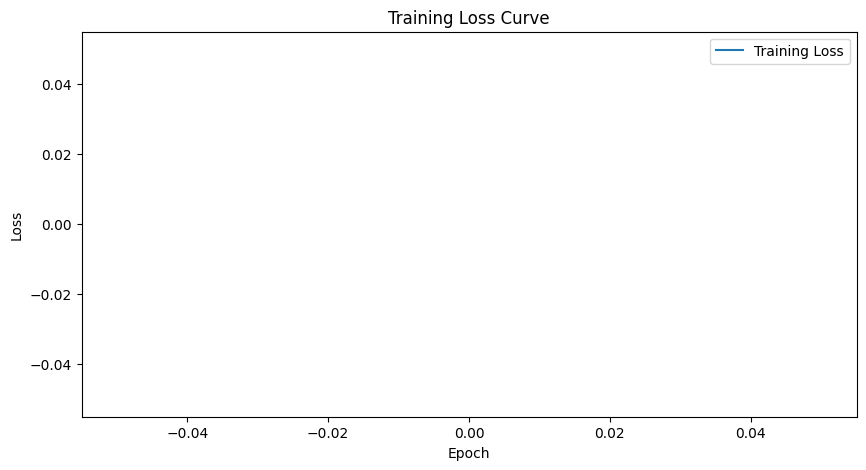

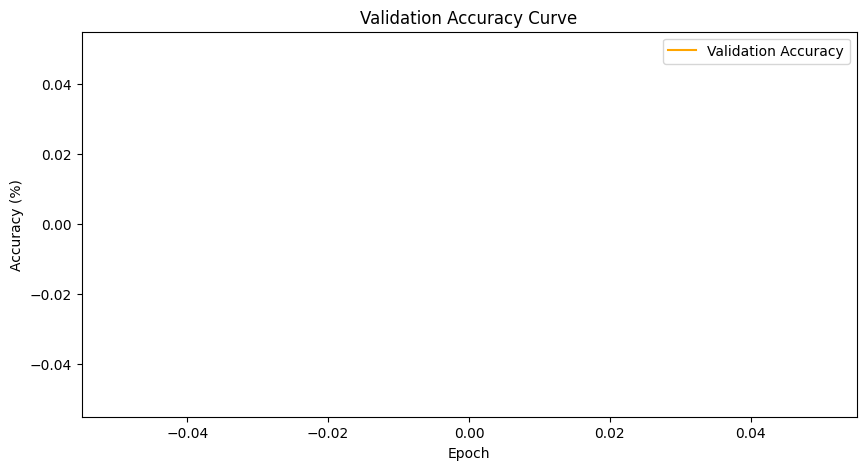

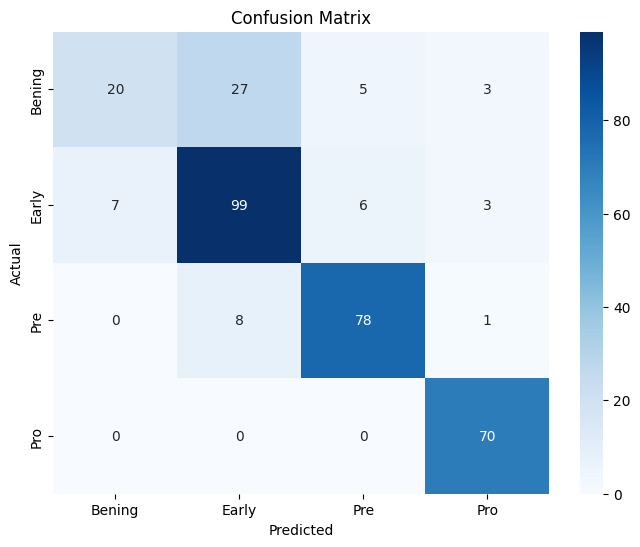

In [59]:
test_model(model, test_loader, disp, train_losses, val_accuracies)

In [65]:
class CNN2(neural.Module):
    def __init__(self, learning_rate, loss_function, optimizer, config, input_size=224, num_classes=4):
        super(CNN2, self).__init__()

        self.learning_rate = learning_rate
        self.loss_function = loss_function
        self.config = config  # ahora se almacena la configuración completa
        self.num_classes = num_classes

        # Construcción dinámica de capas convolucionales
        self.conv_layers = neural.ModuleList()
        in_channels = 3
        W = input_size

        for out_channels, k, s, p in config:
            conv = neural.Conv2d(in_channels, out_channels, kernel_size=k, stride=s, padding=p)
            self.conv_layers.append(conv)
            # Calcular tamaño de salida después de la convolución
            W = calculate_w(W, k, p, s)
            # Pooling 2x2 fijo
            W = calculate_w(W, 2, 0, 2)
            in_channels = out_channels

        # Capas fully-connected
        fc_input_size = in_channels * W * W
        self.linear1 = neural.Linear(fc_input_size, 64)
        self.linear2 = neural.Linear(64, 16)
        self.output = neural.Linear(16, num_classes)

        # Optimizer dentro del modelo
        self.optimizer = get_optimizer(optimizer, self, learning_rate)

    def forward(self, x):
        for conv in self.conv_layers:
            x = function.relu(conv(x))
            x = function.max_pool2d(x, 2)  # pooling fijo 2x2
        x = x.view(x.size(0), -1)
        x = function.relu(self.linear1(x))
        x = function.relu(self.linear2(x))
        x = self.output(x)
        return x

CNN2(
  (loss_function): CrossEntropyLoss()
  (conv_layers): ModuleList(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
    (2): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (linear1): Linear(in_features=23328, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=4, bias=True)
)
Epoch [1/100] | Train Loss: 1.3635 | Val Acc: 24.00%
Epoch [2/100] | Train Loss: 1.1756 | Val Acc: 59.08%
Epoch [3/100] | Train Loss: 0.6157 | Val Acc: 74.77%
Epoch [4/100] | Train Loss: 0.5099 | Val Acc: 75.69%
Epoch [5/100] | Train Loss: 0.4720 | Val Acc: 78.15%
Epoch [6/100] | Train Loss: 0.4030 | Val Acc: 80.00%
Epoch [7/100] | Train Loss: 0.3562 | Val Acc: 83.08%
Epoch [8/100] | Train Loss: 0.3483 | Val Acc: 84.31%
Epoch [9/100] | Train Loss: 0.3157 | Val Acc: 82.15%
Epoch [10/100] | Train Loss: 0.2640 | Val Acc: 83.69%
Epoch [

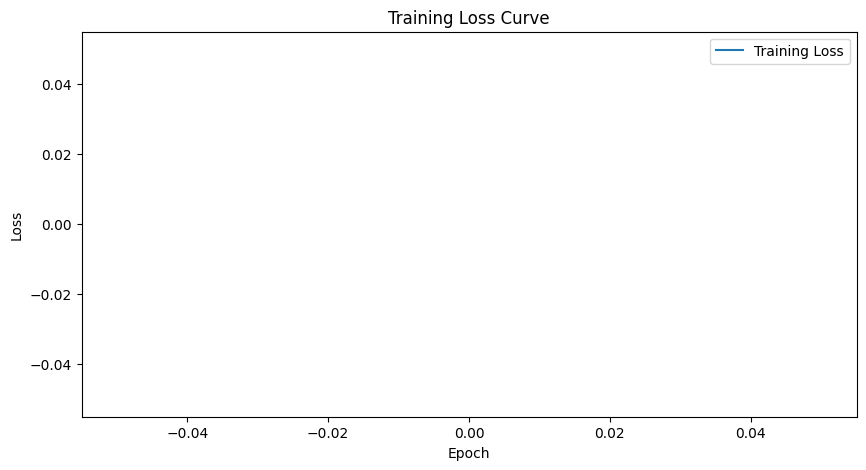

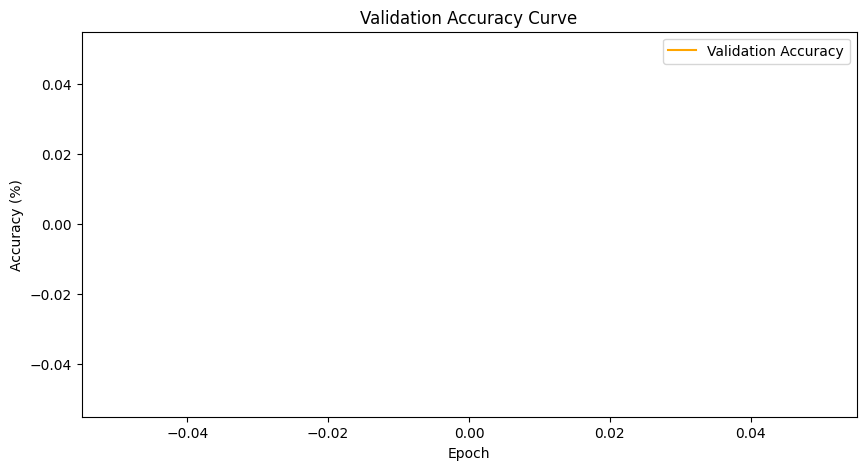

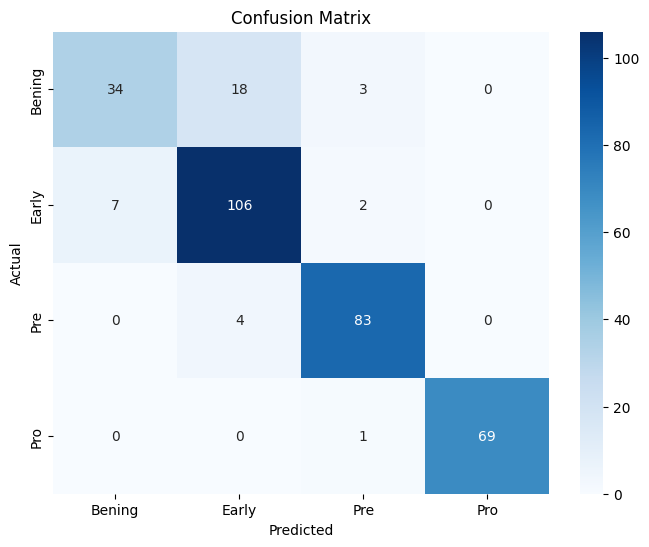

In [66]:
#Definición de hiperparámetros
loss_function2 = torch.nn.CrossEntropyLoss()
optimizer2 = 2
config = [
    [6, 5, 1, 0],
    [12, 3, 1, 0],
    [32, 3, 1, 1]
]

model2 = CNN2(0.001, loss_function2, optimizer2, config, input_size=224, num_classes=4).to(disp)
print(model2)

train_losses, val_accuracies = train_model(model2, train_loader, val_loader, num_epochs, disp)

test_model(model2, test_loader, disp, train_losses, val_accuracies)

# Arquitectura 3

Test Loss: 0.3516 | Test Accuracy: 89.30% | F1 Score: 0.8792


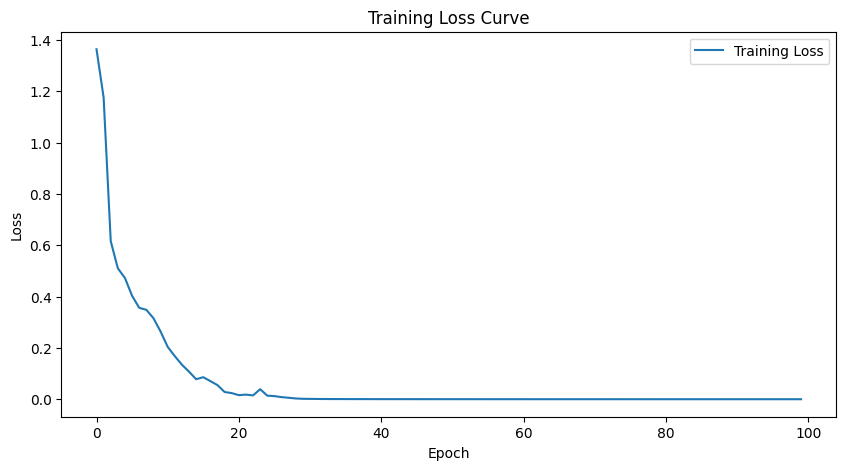

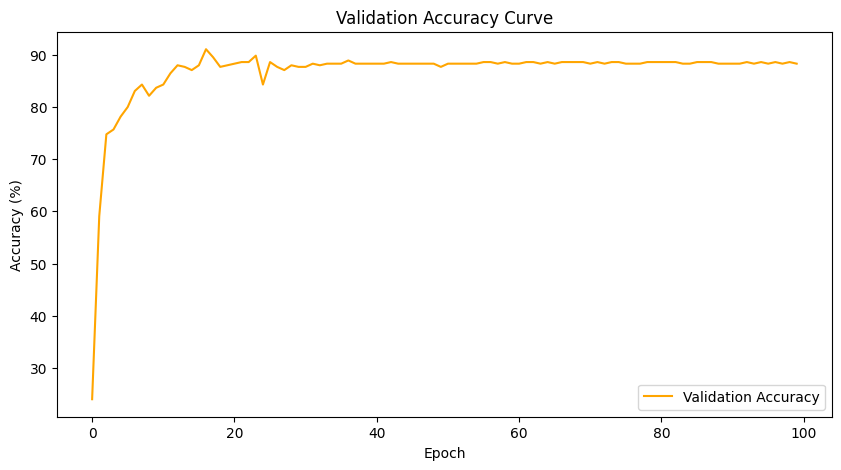

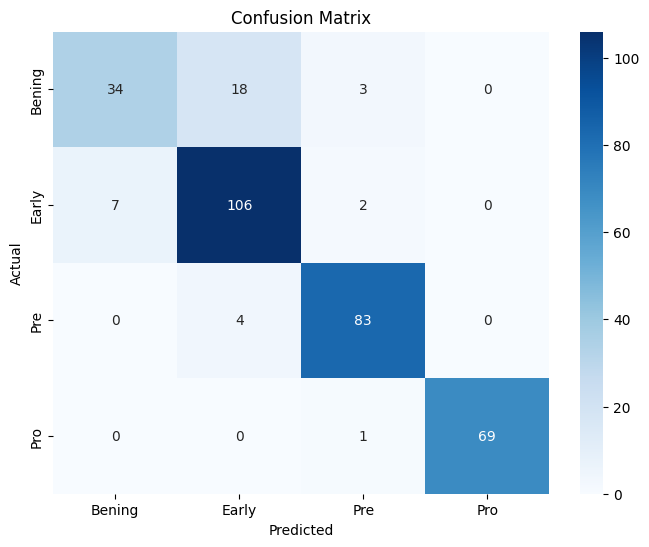

In [73]:
test_model(model2, test_loader, disp, train_losses, val_accuracies)

In [17]:
class ResNet18Wrapper(torch.nn.Module):
    def __init__(self, learning_rate, loss_function, optimizer, num_classes=4, freeze_features=False):
        super(ResNet18Wrapper, self).__init__()

        # Store hyperparameters
        self.learning_rate = learning_rate
        self.loss_function = loss_function
        self.num_classes = num_classes

        # Load pretrained ResNet-18
        self.model = models.resnet18(pretrained=True)

        # Optionally freeze feature extractor
        if freeze_features:
            for param in self.model.parameters():
                param.requires_grad = False

        # Replace final fully connected layer
        num_ftrs = self.model.fc.in_features
        self.model.fc = torch.nn.Linear(num_ftrs, num_classes)

        # Define optimizer
        self.optimizer = get_optimizer(optimizer, self, learning_rate)

    def forward(self, x):
        return self.model(x)


In [20]:
# Define loss function
criterion = torch.nn.CrossEntropyLoss()

# Create model instance
model3 = ResNet18Wrapper(learning_rate, criterion, 2, 4, freeze_features=False)

# Send to device
model3 = model3.to(disp)

# Train with your existing training loop
train_losses, val_accuracies = train_model(model3, train_loader, val_loader, num_epochs, disp)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/100] | Loss: 0.1426 | Val Acc: 96.00%
Epoch [2/100] | Loss: 0.0513 | Val Acc: 78.46%
Epoch [3/100] | Loss: 0.0205 | Val Acc: 95.08%
Epoch [4/100] | Loss: 0.0328 | Val Acc: 38.15%
Epoch [5/100] | Loss: 0.0354 | Val Acc: 90.77%
Epoch [6/100] | Loss: 0.0131 | Val Acc: 99.38%
Epoch [7/100] | Loss: 0.0017 | Val Acc: 99.08%
Epoch [8/100] | Loss: 0.0008 | Val Acc: 99.38%
Epoch [9/100] | Loss: 0.0004 | Val Acc: 99.69%
Epoch [10/100] | Loss: 0.0003 | Val Acc: 99.69%
Epoch [11/100] | Loss: 0.0001 | Val Acc: 99.38%
Epoch [12/100] | Loss: 0.0003 | Val Acc: 99.69%
Epoch [13/100] | Loss: 0.0004 | Val Acc: 99.38%
Epoch [14/100] | Loss: 0.0002 | Val Acc: 99.69%
Epoch [15/100] | Loss: 0.0001 | Val Acc: 99.08%
Epoch [16/100] | Loss: 0.0001 | Val Acc: 99.38%
Epoch [17/100] | Loss: 0.0004 | Val Acc: 99.69%
Epoch [18/100] | Loss: 0.0003 | Val Acc: 99.08%
Epoch [19/100] | Loss: 0.0002 | Val Acc: 99.38%
Epoch [20/100] | Loss: 0.0001 | Val Acc: 99.08%
Epoch [21/100] | Loss: 0.0001 | Val Acc: 99.38%
E

In [ ]:
test_model(model3,test_loader,disp, train_losses, val_accuracies)